In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(1559, 20)
(1559, 3)


In [6]:
X_motion_CoM[0, :]

array([0.0, 0.0, 0.0, 0.23939470946788788, 0.12513311207294464,
       -0.3820335566997528, 0.24643272161483765, -0.13321122527122498,
       -0.3814055025577545, -0.2567279636859894, 0.12573184072971344,
       -0.38702353835105896, -0.26360762119293213, -0.12588781118392944,
       -0.3810579478740692, 0.0, 0.0, 0.0, False, True], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(778,)

In [10]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, 0.0, 0.24316425621509552, 0.12834718823432922,
       -0.3836668133735657, 0.23878607153892517, -0.131938174366951,
       -0.36480507254600525, -0.2585662603378296, 0.12253835797309875,
       -0.3686639368534088, -0.25985878705978394, -0.12464121729135513,
       -0.3830992579460144, 0.1, 0.0, 0.0, True, False], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.0002006561349540137, -0.005639766167924484,
       0.0009616162325033761], dtype=object)

## Predict CoM -> x

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9691771549703625
RMSE:  0.011384348566240437
The lowest error is:  4.600244797720032e-05
The highest error is:  0.057614163826230747
The avg. error is:  0.006976020880437324


In [13]:
model_fl_com_x.coef_

array([[ 1.10969766e-01, -1.11022302e-16, -4.44089210e-16,
         1.90094360e-02,  3.60822483e-16,  1.11022302e-16,
        -2.36825629e-01, -1.00537558e-01,  6.22377531e-01,
         9.46341124e-01, -2.10762782e-01, -5.90307915e-01,
        -5.70401960e-01, -7.66127094e-01]])

In [14]:
model_fl_com_x.intercept_

array([-0.18558678])

In [15]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[-0.02051249]])

Text(0, 0.5, 'Predictions')

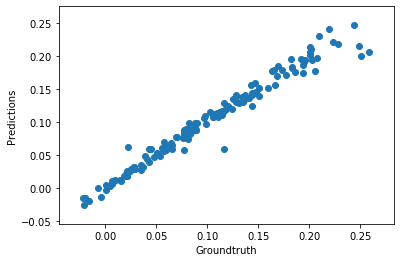

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
#%store model_fl_com_x

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.25198387518370036
RMSE:  0.0034020681074180908
The lowest error is:  1.2586490506991121e-06
The highest error is:  0.012190236404910348
The avg. error is:  0.0026097591701461816


In [21]:
model_fl_com_y.coef_

array([[ 6.68522783e-03,  8.67361738e-18, -4.43438689e-17,
        -8.52426399e-03,  1.52655666e-16,  1.11022302e-16,
        -7.10360481e-02, -6.67172540e-01,  4.77960933e-02,
         1.83333411e-01, -7.13706874e-02,  2.64643709e-01,
         2.74425862e-02, -2.54936571e-01]])

In [22]:
model_fl_com_y.intercept_

array([0.03697627])

Text(0, 0.5, 'Predictions')

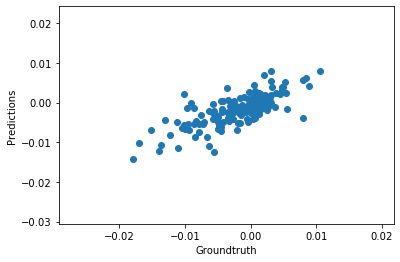

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [24]:
#%store model_fl_com_y

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [26]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [27]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -0.9529577837603505
RMSE:  0.0035339511278155724
The lowest error is:  8.138722190655784e-06
The highest error is:  0.03453209842063936
The avg. error is:  0.0019616729223983866


In [28]:
model_fl_com_theta.coef_

array([[-8.06173264e-03,  2.49366500e-17,  1.73472348e-18,
         1.87572844e-03,  5.55111512e-17, -1.38777878e-17,
        -1.98210122e-02, -9.24479952e-02,  4.62743996e-02,
         8.73143731e-02, -2.68573367e-02, -3.76786247e-02,
         5.74811800e-02,  1.04968675e-01]])

In [29]:
model_fl_com_theta.intercept_

array([0.0439839])

Text(0, 0.5, 'Predictions')

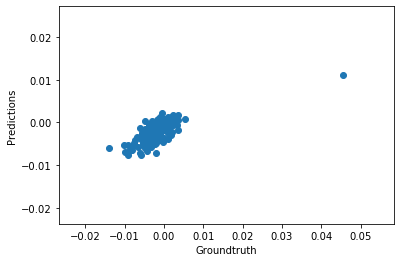

In [30]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")